In [137]:
from bs4 import BeautifulSoup
import re
import os
import glob
from tqdm import tqdm
import pandas as pd
from builtins import UnicodeDecodeError
import xml.etree.ElementTree as ET

In [138]:
audio_base_folder = "data/swissubase_2277_1_0/archimob_r2_audio_share/audio_segmented_anonymized"

In [139]:
xml_base_folder = "data/swissubase_2269_1_0/Archimob_Release_2/Archimob_Release_2"
xml_file_path_list = glob.glob(xml_base_folder+"/*.xml")
xml_file_path_list = [file.replace("\\","/") for file in xml_file_path_list]
xml_file_path_list

['data/swissubase_2269_1_0/Archimob_Release_2/Archimob_Release_2/1007.xml',
 'data/swissubase_2269_1_0/Archimob_Release_2/Archimob_Release_2/1008.xml',
 'data/swissubase_2269_1_0/Archimob_Release_2/Archimob_Release_2/1044.xml',
 'data/swissubase_2269_1_0/Archimob_Release_2/Archimob_Release_2/1048.xml',
 'data/swissubase_2269_1_0/Archimob_Release_2/Archimob_Release_2/1053.xml',
 'data/swissubase_2269_1_0/Archimob_Release_2/Archimob_Release_2/1055.xml',
 'data/swissubase_2269_1_0/Archimob_Release_2/Archimob_Release_2/1063.xml',
 'data/swissubase_2269_1_0/Archimob_Release_2/Archimob_Release_2/1073.xml',
 'data/swissubase_2269_1_0/Archimob_Release_2/Archimob_Release_2/1075.xml',
 'data/swissubase_2269_1_0/Archimob_Release_2/Archimob_Release_2/1082_1.xml',
 'data/swissubase_2269_1_0/Archimob_Release_2/Archimob_Release_2/1082_2.xml',
 'data/swissubase_2269_1_0/Archimob_Release_2/Archimob_Release_2/1082_3.xml',
 'data/swissubase_2269_1_0/Archimob_Release_2/Archimob_Release_2/1083_1.xml',
 'da

In [217]:
audio_file_path_list = []
utterance_swiss_german_list = []
utterance_standard_german_list =[]
speaker_list = []
for file in xml_file_path_list:
    audio_folder_number = file.split("/")[-1].split(".")[0]
    tree = ET.parse(file)
    root = tree.getroot()
    for child in root:
        if "text"in child.tag:
            #print(f"Tag: {child.tag}, Attributes: {child.attrib}, Text: {child.text}")
            for subchild in child:
                if "body"in subchild.tag:
                    #print(f"\t Tag: {subchild.tag}, Attributes: {subchild.attrib}, Text: {subchild.text}")
                    for subchild2 in subchild:
                        if "u"in subchild2.tag:
                            #print(f"\t\t Tag: {subchild2.tag}, Attributes: {subchild2.attrib}, Text: {subchild2.text}")
                            speaker = subchild2.attrib.get('who')
                            media_pointer = re.sub("media_pointers#", "", subchild2.attrib.get('start'))
                            media_pointer = re.sub("-", "_", media_pointer)
                            audio_file_name = media_pointer + ".wav"
                            audio_file_path = os.path.join(audio_base_folder, audio_folder_number, audio_file_name).replace("\\","/") #os.getcwd(), 
                            if os.path.exists (audio_file_path):
                                utterance_swiss_german = ""
                                utterance_standard_german = ""
                                for subchild3 in subchild2:
                                    if "w"in subchild3.tag and not "del" in subchild3.tag and not "pause" in subchild3.tag:
                                        #print(f"\t\t\t Tag: {subchild3.tag}, Attributes: {subchild3.attrib}, Text: {subchild3.text}")
                                        swiss_german_word_text = subchild3.text
                                        standard_german_word_text = subchild3.attrib.get("normalised")
                                        if swiss_german_word_text:
                                            utterance_swiss_german = utterance_swiss_german + " " + swiss_german_word_text
                                        if standard_german_word_text:
                                            utterance_standard_german= utterance_standard_german + " " + standard_german_word_text
                                #print(audio_file_path, utterance_swiss_german, utterance_standard_german)
                                audio_file_path_list.append(audio_file_path)
                                utterance_swiss_german_list.append(utterance_swiss_german)
                                utterance_standard_german_list.append(utterance_standard_german)
                                speaker_list.append(speaker)

In [218]:
data = pd.DataFrame({"audio": audio_file_path_list, 
                     "speaker": speaker_list,
                     "sentence":utterance_swiss_german_list, 
                     "sentence_standard_ger": utterance_standard_german_list})            

In [219]:
data.shape

(79854, 4)

In [220]:
data.sentence_standard_ger = (data["sentence_standard_ger"].apply(lambda x: re.sub('\n', ' ', x))
                 .apply(lambda x: re.sub(r'\s+', ' ', x))
                .apply(lambda x: x.strip())
                .apply(lambda x: re.sub(r'\.{2,}','', x)))

In [221]:
data.sentence = (data["sentence"].apply(lambda x: re.sub('\n', ' ', x))
                 .apply(lambda x: re.sub(r'\s+', ' ', x))
                .apply(lambda x: x.strip())
                .apply(lambda x: re.sub(r'\.{2,}','', x)))

In [222]:
data = data[~((data.sentence.apply(lambda x: (len(x)<3))) & (data.sentence_standard_ger.apply(lambda x: (len(x)<3))))]

In [223]:
data = data[data.sentence.apply(lambda x: True if re.search(r'\w', x) else False)]
data = data[data.sentence_standard_ger.apply(lambda x: True if re.search(r'\w', x) else False)]

In [224]:
data.head()

,audio,speaker,sentence,sentence_standard_ger
0,data/swissubase_2277_1_0/archimob_r2_audio_sha...,interviewer,chönd sii,können sie
1,data/swissubase_2277_1_0/archimob_r2_audio_sha...,interviewer,iri jugendziit beschriibe,ihre jugendzeit beschreiben
2,data/swissubase_2277_1_0/archimob_r2_audio_sha...,person_db#EJos1007,jaa,ja
3,data/swissubase_2277_1_0/archimob_r2_audio_sha...,person_db#EJos1007,ich wän das ich geboore bì,ich wann dass ich geboren bin
4,data/swissubase_2277_1_0/archimob_r2_audio_sha...,interviewer,jaa,ja


In [225]:
data.to_csv("audio_df_umlauts.csv")

In [226]:
sum(data.sentence.apply(lambda x: len(x)))/len(data) #mean number of chars

37.674668765577856

In [227]:
metadf = pd.read_csv("data/swissubase_2269_1_0/Metadata.txt", sep="\t")

In [228]:
metadf.head()

,DocID,SpeakerID,Year of birth,Sex,Profession,Dialect area,Transcriptor,Tool,Transcription phase,Normalisation
0,1007,EJos1007,1912,f,Haushaltsgehilfin,NW (Stans),Peters,Nisus Writer,1,manual
1,1008,BVin1008,1928,m,Manager (unklar),LU (Meggen),Aepli,Exmaralda,3,automatic
2,1044,WFra1044,1913,m,Ökonom,BS (Basel),Aepli,Exmaralda,4,automatic
3,1048,WRos1048,1925,f,Hausfrau/Familienunternehmen,GL (Enneda),Peters,Nisus Writer,1,manual
4,1053,OJos1053,1932,m,Bauer,NW (Wolfenschiessen),Aepli,Exmaralda,4,automatic


In [229]:
data["speaker_normalised"] = data.speaker.apply(lambda x: re.sub("person_db#","",x))

In [230]:
meta_merged_df = pd.merge(data, metadf[["SpeakerID", "Year of birth", "Sex", "Profession", "Dialect area"]], 
         how='right', left_on="speaker_normalised", right_on="SpeakerID")

In [231]:
meta_merged_df.shape

(63012, 10)

In [232]:
meta_merged_df.shape

(63012, 10)

In [233]:
meta_merged_df["Dialect area"].value_counts()

Dialect area
AG (Buchs/Zofingen)            6714
BS (Basel)                     6223
ZH (Zürich)                    5925
ZH (Winterthur)                4316
AG (Baden)                     3933
AG (Baden/Brugg)               2500
SG (Brütten ZH/Zuozwil)        2404
BE (Bern/Bangerten)            2295
AG (Full-Reuenthal)            2266
ZH (Zürich-Seebach)            2036
GL (Näfels)                    1956
BE (Erlach)                    1898
ZH (Wallisellen)               1867
LU (Meggen)                    1828
ZH/BS (Zürich/??)              1563
ZH (Wülflingen)                1524
GL (Enneda)                    1515
LU (Luzern)                    1360
SH (Ramsen)                    1348
NW (Wolfenschiessen)           1208
LU (Sempach)                   1097
BE (Bern/Köniz)                1073
VS (Naters)                     930
NW (Stans)                      917
UR (Göschener Alp)              910
BE (Matten b. Interlaken)       891
BE (Bern/Ittigen)               785
SZ (Schwyz)    

In [234]:
meta_merged_df["Dialect area"].apply(lambda x: re.sub(" \(.*\)","",x)).value_counts()

Dialect area
ZH       15922
AG       15414
BE        6942
BS        6223
LU        4705
GL        3471
SG        2404
NW        2125
ZH/BS     1563
SH        1348
VS         930
UR         910
SZ         717
GR         337
BL           1
Name: count, dtype: int64

In [235]:
value_count_canton = meta_merged_df["Dialect area"].apply(lambda x: re.sub(" \(.*\)","",x)).value_counts()
canton_proportion_df = pd.DataFrame({"Canton": value_count_canton.index,
                                    "value":value_count_canton.values })#.plot.pie( figsize=(5, 5))

In [236]:
import matplotlib.pyplot as plt

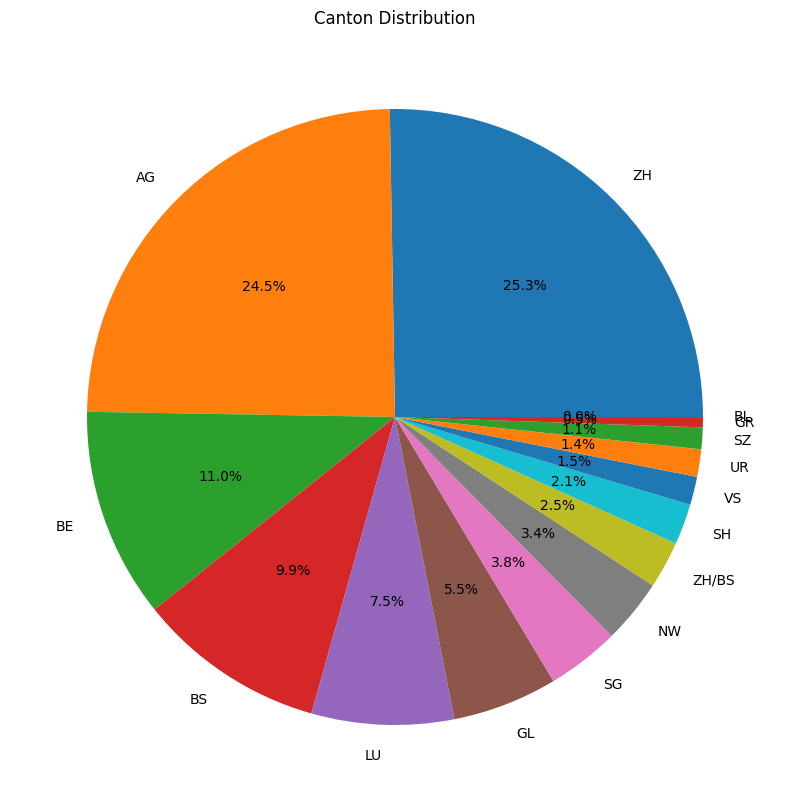

In [237]:
fig, ax = plt.subplots(figsize=(10, 10))  # Create a figure and an axis
canton_proportion_df.plot.pie(y='value',ax=ax,autopct='%1.1f%%',  legend=False, labels=canton_proportion_df.Canton,  title="Canton Distribution")
# Add a legend manually and place it in the top-right corner, outside the plot
#plt.legend(labels=canton_proportion_df.Canton, loc='upper right', bbox_to_anchor=(1.3, 1))
plt.ylabel('')  # Remove default y-axis label
plt.show()


<Axes: ylabel='value'>

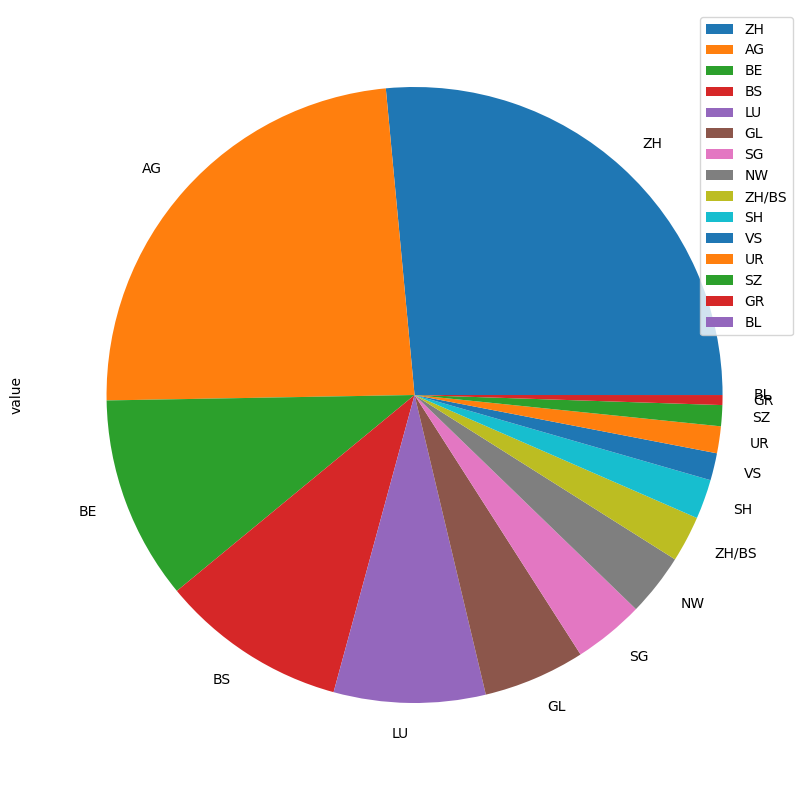

In [205]:
canton_proportion_df.plot.pie(y='value', figsize=(10, 10), labels=canton_proportion_df.Canton)